# Generate probability map from NLI Output 
Exp 1: What is a better ring pixel (1, 2, 4, 8, 16?)
Exp 2: If we choose to smooth the probability map, how should we do it? 

In [17]:
import numpy as np
import scipy.io
from scipy.ndimage import binary_dilation, distance_transform_edt, gaussian_filter
import matplotlib.pyplot as plt

In [ ]:
def prob_map_generator(mu_dir, threshold=6000.0, ring_size=1, smooth=None):
    """
    Generates a probability map from the given mu_dir and ring_size.
    
    Parameters:
    - mu_dir: Directory containing the mu.mat file.
    - ring_size: Size of the ring, pixel ring size = 1 unless otherwise specified.
    - threshold: Threshold for the probability map, default is 6000 (kPa).
    - smooth: Optional smoothing parameter.
    
    Returns:
    - prob_map: The generated probability map.
    """
    
    # Load mu.mat file
    mu = scipy.io.loadmat(mu_dir)['Mu']
    # initialize the final probability map 
    final_prob_maps = []
    
    for slice in range(mu.shape[2]):
        slice_data = mu[:, :, slice]
        H, W = slice_data.shape

        # Create mask of NaNs
        nan_mask = np.isnan(slice_data)

        # Define edge: 4-pixel ring around NaN
        # edge_mask_2 = binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(binary_dilation(nan_mask)))))))) & ~nan_mask
        edge_mask_2 = binary_dilation(nan_mask, iterations=ring_size) & ~nan_mask
        
        # High-stiffness regions (to penalize if near edge)
        high_stiff_mask = (slice_data >= threshold) & ~nan_mask

        # Compute distance from each pixel to edge (Euclidean)
        dist_to_edge = distance_transform_edt(~edge_mask_2)  # higher = farther from edge

        # Normalize distances to [0, 1] range
        dist_norm = dist_to_edge / np.max(dist_to_edge)

        # Probability map: default to 1 (fully trusted)
        prob_map = np.ones((H, W))

        # Penalize high-stiffness pixels: closer to edge = lower prob
        prob_map[high_stiff_mask] = dist_norm[high_stiff_mask]  # e.g., 0 near edge, 1 deep inside

        # NaNs always get 0 (common sense)
        prob_map[nan_mask] = 0
        
        if smooth:
            prob_map = gaussian_filter(prob_map, sigma=smooth) # gentle smoothing 
        
        
        # TODO: decide if we want to keep hard zeros at NaN locations
        final_prob_maps.append(prob_map)

    # Stack slices into 3D volume
    final_prob_volume = np.stack(final_prob_maps, axis=-1)
    return final_prob_volume
        

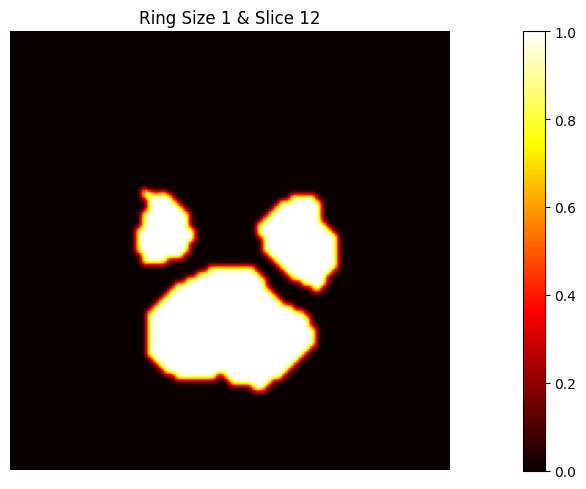

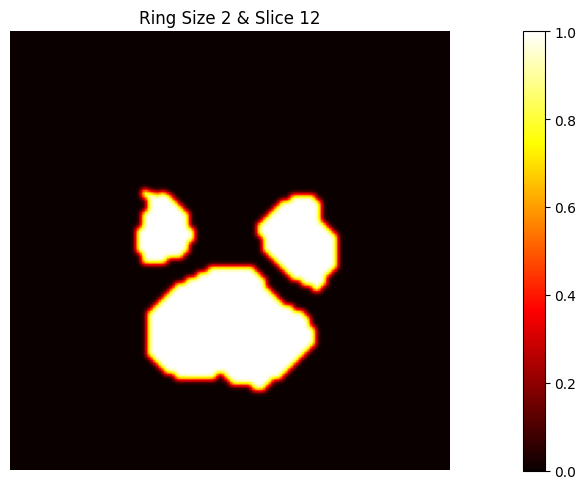

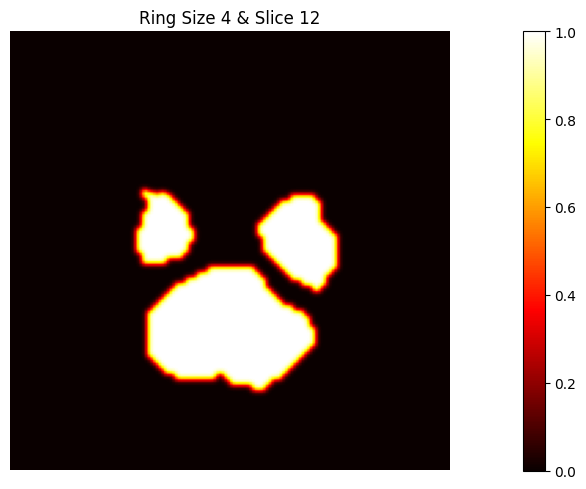

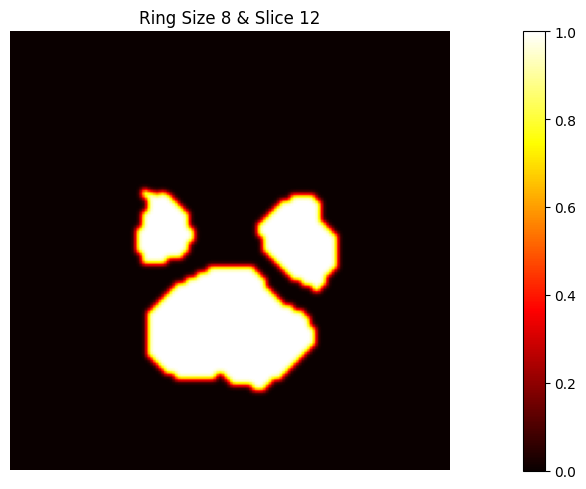

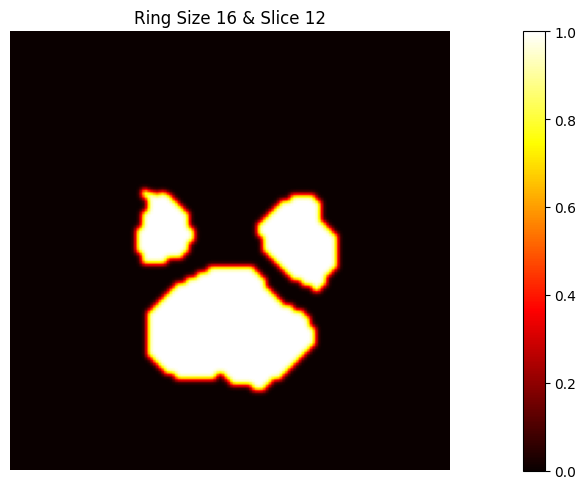

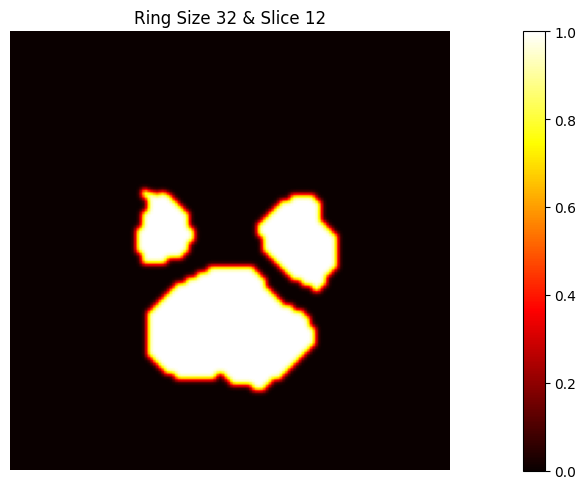

In [28]:
# Experiment through differnt ring size and observe the impacts on slice 10, 20, 30, and 40 respectively 
# Plot the graphs 
# Dilation to try: 1, 2, 4, 8, 16 

ring_size = [1, 2, 4, 8, 16, 32]

slices_to_show = [12]

for i in ring_size:
    final_prob_volume = prob_map_generator("/home/smooi/Desktop/toast/data/toast_pipe_data/aEA_1046/Mu.mat", ring_size=i)
    plt.figure(figsize=(15, 5))  # Adjust figure size for better visualization

    for idx, slice_idx in enumerate(slices_to_show):
        plt.subplot(1, len(slices_to_show), idx + 1)
        plt.imshow(final_prob_volume[:, :, slice_idx], cmap='hot', vmin=0, vmax=1)
        plt.colorbar()
        plt.title(f'Ring Size {i} & Slice {slice_idx}')
        plt.axis('off')  # Turn off axis for cleaner visualization

    plt.tight_layout()
    plt.show()


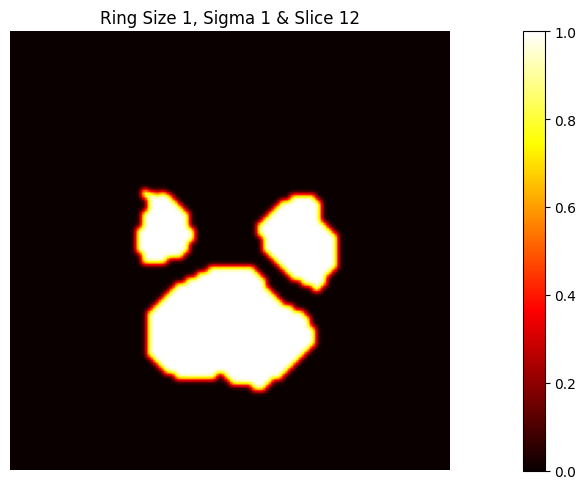

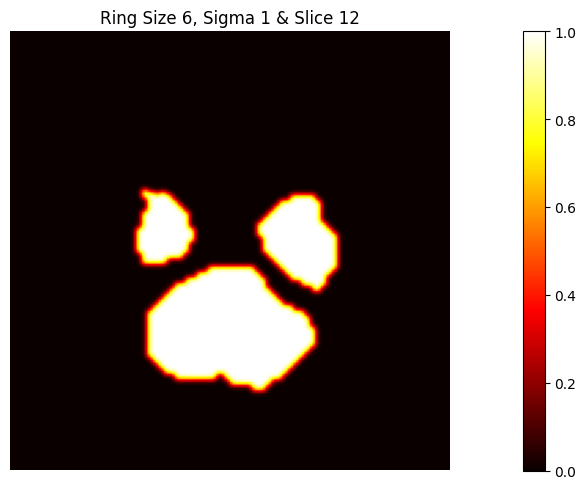

In [36]:
# Dilation to try: 1, 2, 4, 8, 16 

ring_size = [1, 6]
sigma = [1]
slices_to_show = [12]

for i in ring_size:
    for s in sigma:
        final_prob_volume = prob_map_generator("/home/smooi/Desktop/toast/data/toast_pipe_data/aEA_1046/Mu.mat", ring_size=i, smooth=s)
        plt.figure(figsize=(15, 5))  # Adjust figure size for better visualization

        for idx, slice_idx in enumerate(slices_to_show):
            plt.subplot(1, len(slices_to_show), idx + 1)
            plt.imshow(final_prob_volume[:, :, slice_idx], cmap='hot')
            plt.colorbar()
            plt.title(f'Ring Size {i}, Sigma {s} & Slice {slice_idx}')
            plt.axis('off')  # Turn off axis for cleaner visualization

        plt.tight_layout()
        plt.show()

In [33]:
mu_dir = "/home/smooi/Desktop/toast/data/toast_pipe_data/aEA_1046/Mu.mat"
out1 = prob_map_generator(mu_dir, ring_size=2, smooth=1)
out2 = prob_map_generator(mu_dir, ring_size=64, smooth=1)
middle_slice = 20 
diff = np.abs(out2 - out1)
print("Max diff:", np.max(diff))


Max diff: 0.21700472966074968


It is hard to experiment and obtain which is the best value for smooth and pixel ring size. let's just keep this ring size to 2 and keep the smooth to be 1 for now. 

In [34]:
# Transfer all the Mu files in subject directory to stiff_prob.mat 
from pathlib import Path
root_dir = Path("/home/smooi/Desktop/toast/data/toast_pipe_data") 
subject_dir = [d.name for d in root_dir.iterdir() if d.is_dir() and d.name != "empty_data"]
print(subject_dir)

# apply the above function, smooth sigma = 1, ring size = 2, and save the files to the subject directory
for subject in subject_dir:
    mu_dir = root_dir / subject / "Mu.mat"
    if mu_dir.exists():
        prob_map = prob_map_generator(mu_dir, ring_size=2, smooth=1)
        output_file = root_dir / subject / "stiff_prob.mat"
        scipy.io.savemat(output_file, {'stiff_prob': prob_map})
        print(f"Saved {output_file}")
    else:
        print(f"Mu.mat not found in {subject}")

['aEA_1048A', 'aU01_D2002', 'Nemours_0007', 'Nemours_0017', 'aEA_1050A', '2023-U7487-0733-DF', 'Nemours_0033', '2023-U7487-00424-TM', 'Nemours_0014', 'Nemours_0008', 'Cc_116', '2023-U7487-0632-LK', 'Cc_108Pre', 'aEA_1073B', '2023-U7487-0706-VP', 'Nemours_0022', 'Nemours_0027', 'Nemours_0001', 'Nemours_0037', 'Nemours_0015', 'aEA_1046', 'aU01_005', 'Nemours_0010', 'Nemours_0039', '2023-U7487-0613-CT', 'Nemours_0019', 'aEA_1072A', 'Cc_104Post', 'Cc_115', 'Cc_106', '2023-U7487-00411-NP', 'Cc_101', 'Nemours_0034', 'Cc_104Pre', 'Nemours_0030', 'Cc_103Pre', 'Nemours_0031', 'Cc_MreVolHsrb204', 'Nemours_0016', 'Nemours_0005', 'Nemours_0032', 'Nemours_0002', '2023-U7487-0208-MN', 'aSTE_016', 'MreVol_9', '2023-U7778-0177-EC', 'aSTE_007', 'Nemours_0003', '2023-U7487-00427-MG', 'Nemours_0024', 'aEA_1050B', 'Nemours_0023', 'Nemours_0006', 'Cc_105', 'MreVol_3', 'aEA_1056A', 'Cc_111', 'aU01_003', 'MreVol_4', 'aSTE_001', 'aSTE_018', 'Nemours_0029', 'Nemours_0011', '2023-U7487-0719-MS', 'MreVol_6', '20